<a href="https://colab.research.google.com/github/alim98/MPI/blob/main/MPI_VITANDVGG_enhanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O downloaded_file.zip "https://drive.usercontent.google.com/download?id=1iHPBdBOPEagvPTHZmrN__LD49emXwReY&export=download&authuser=0&confirm=t&uuid=631d60dd-569c-4bb1-a9e8-d681f0ed3d43&at=APvzH3r4me8x_LwP3n8O7lgPo8oK%3A1733988188000"

!unzip downloaded_file.zip

In [ ]:

!pip install transformers scikit-learn matplotlib seaborn torch torchvision umap-learn git+https://github.com/funkelab/funlib.learn.torch.git
!pip install openpyxl


In [ ]:

import os
import glob
import imageio.v2 as iio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle
from torch.utils.data import Dataset, DataLoader
from transformers import ViTImageProcessor, ViTModel
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from umap import UMAP
import torch.nn.functional as F
from funlib.learn.torch.models import Vgg3D

Total synapses loaded from all bboxes: 220
Combined Dataset and DataLoader initialized.
VGG3D checkpoint already exists.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-1-b3e9154816dd>:184: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary 

VGG3D model loaded and in eval mode.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ViT model loaded and in eval mode.
Processed 10 batches.
Extracted combined features for 220 synapses.


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

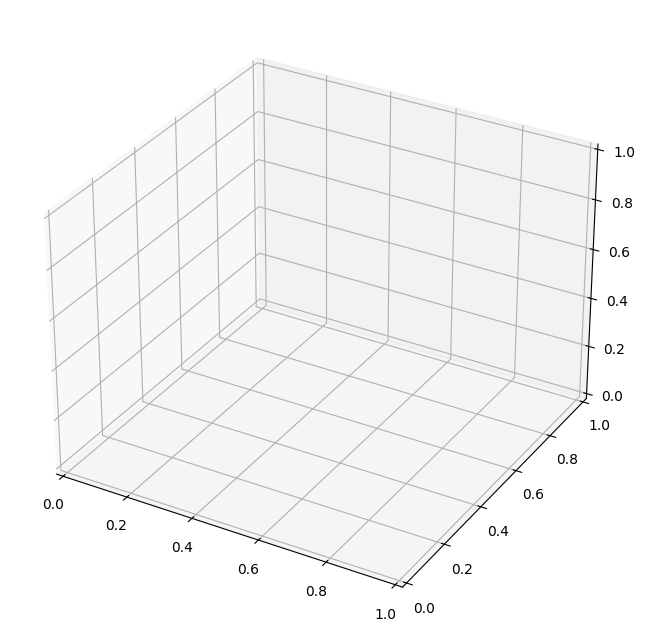

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from transformers import ViTImageProcessor, ViTModel
from funlib.learn.torch.models import Vgg3D
import seaborn as sns
import umap
from PIL import Image
import imageio.v2 as iio
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import torch.nn.functional as F


raw_base_dir = '/content/raw'
seg_base_dir = '/content/seg'
bbox_names = [f'bbox{i}' for i in range(1,4)]  # bbox1 to bbox4 because in google colab im running out of RAM

def load_bbox_data(bbox_name, max_slices=None):
    raw_dir = os.path.join(raw_base_dir, bbox_name)
    seg_dir = os.path.join(seg_base_dir, bbox_name)

    raw_tif_files = sorted(glob.glob(os.path.join(raw_dir, 'slice_*.tif')))
    seg_tif_files = sorted(glob.glob(os.path.join(seg_dir, 'slice_*.tif')))

    if max_slices is not None:
        raw_tif_files = raw_tif_files[:max_slices]
        seg_tif_files = seg_tif_files[:max_slices]

    assert len(raw_tif_files) == len(seg_tif_files), f"Raw/Seg mismatch in {bbox_name}"

    raw_slices = [iio.imread(f) for f in raw_tif_files]
    seg_slices = [iio.imread(f).astype(np.uint32) for f in seg_tif_files]

    raw_vol = np.stack(raw_slices, axis=0)  # (Z, Y, X)
    seg_vol = np.stack(seg_slices, axis=0)  # (Z, Y, X)
    return raw_vol, seg_vol

def create_segment_masks(seg_vol, side1_coord, side2_coord):
    x1, y1, z1 = [int(c) for c in side1_coord]
    x2, y2, z2 = [int(c) for c in side2_coord]

    seg_id_1 = seg_vol[z1, y1, x1]
    seg_id_2 = seg_vol[z2, y2, x2]

    mask_1 = (seg_vol == seg_id_1) if seg_id_1 != 0 else np.zeros_like(seg_vol, dtype=bool)
    mask_2 = (seg_vol == seg_id_2) if seg_id_2 != 0 else np.zeros_like(seg_vol, dtype=bool)
    return mask_1, mask_2

class SynapseDataset(Dataset):
    def __init__(self, vol_data_list, combined_synapse_df, subvol_size=80):
        self.vol_data_list = vol_data_list
        self.synapse_df = combined_synapse_df.reset_index(drop=True)
        self.subvol_size = subvol_size
        self.half_size = subvol_size // 2

    def __len__(self):
        return len(self.synapse_df)

    def __getitem__(self, idx):
        syn_info = self.synapse_df.iloc[idx]
        bbox_index = syn_info['bbox_index']
        raw_vol, seg_vol = self.vol_data_list[bbox_index]

        central_coord = (
            int(syn_info['central_coord_1']),
            int(syn_info['central_coord_2']),
            int(syn_info['central_coord_3'])
        )
        side1_coord = (
            int(syn_info['side_1_coord_1']),
            int(syn_info['side_1_coord_2']),
            int(syn_info['side_1_coord_3'])
        )
        side2_coord = (
            int(syn_info['side_2_coord_1']),
            int(syn_info['side_2_coord_2']),
            int(syn_info['side_2_coord_3'])
        )

        mask_1_full, mask_2_full = create_segment_masks(seg_vol, side1_coord, side2_coord)

        cx, cy, cz = central_coord
        x_start = max(cx - self.half_size, 0)
        x_end = min(cx + self.half_size, raw_vol.shape[2])
        y_start = max(cy - self.half_size, 0)
        y_end = min(cy + self.half_size, raw_vol.shape[1])
        z_start = max(cz - self.half_size, 0)
        z_end = min(cz + self.half_size, raw_vol.shape[0])

        sub_raw = raw_vol[z_start:z_end, y_start:y_end, x_start:x_end]
        sub_mask_1 = mask_1_full[z_start:z_end, y_start:y_end, x_start:x_end]
        sub_mask_2 = mask_2_full[z_start:z_end, y_start:y_end, x_start:x_end]

        desired_shape = (self.subvol_size, self.subvol_size, self.subvol_size)
        padded_sub_raw = np.zeros(desired_shape, dtype=sub_raw.dtype)
        padded_sub_mask_1 = np.zeros(desired_shape, dtype=bool)
        padded_sub_mask_2 = np.zeros(desired_shape, dtype=bool)

        dz, dy, dx = sub_raw.shape
        padded_sub_raw[:dz, :dy, :dx] = sub_raw
        padded_sub_mask_1[:dz, :dy, :dx] = sub_mask_1
        padded_sub_mask_2[:dz, :dy, :dx] = sub_mask_2

        axial_slice = padded_sub_raw[self.half_size, :, :]     # XY
        coronal_slice = padded_sub_raw[:, self.half_size, :]   # XZ
        sagittal_slice = padded_sub_raw[:, :, self.half_size]  # YZ

        sub_raw_tensor = torch.from_numpy(padded_sub_raw).unsqueeze(0).float()
        axial_slice_tensor = torch.from_numpy(axial_slice).unsqueeze(0).float()
        coronal_slice_tensor = torch.from_numpy(coronal_slice).unsqueeze(0).float()
        sagittal_slice_tensor = torch.from_numpy(sagittal_slice).unsqueeze(0).float()

        return sub_raw_tensor, [axial_slice_tensor, coronal_slice_tensor, sagittal_slice_tensor]

vol_data_list = []
combined_synapse_df_list = []
for i, bbox_name in enumerate(bbox_names):
    raw_vol, seg_vol = load_bbox_data(bbox_name)
    vol_data_list.append((raw_vol, seg_vol))
    excel_file = f'{bbox_name}.xlsx'
    syn_df = pd.read_excel(excel_file)
    syn_df['bbox_index'] = i
    syn_df['bbox_name'] = bbox_name
    combined_synapse_df_list.append(syn_df)

combined_synapse_df = pd.concat(combined_synapse_df_list, ignore_index=True)
required_columns = [
    'central_coord_1', 'central_coord_2', 'central_coord_3',
    'side_1_coord_1', 'side_1_coord_2', 'side_1_coord_3',
    'side_2_coord_1', 'side_2_coord_2', 'side_2_coord_3'
]
missing_columns = [col for col in required_columns if col not in combined_synapse_df.columns]
if missing_columns:
    raise KeyError(f"Missing required columns: {missing_columns}")

print(f"Total synapses loaded from all bboxes: {len(combined_synapse_df)}")

dataset = SynapseDataset(vol_data_list, combined_synapse_df, subvol_size=80)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=4)
print("Combined Dataset and DataLoader initialized.")

checkpoint_url = "https://dl.dropboxusercontent.com/scl/fo/mfejaomhu43aa6oqs6zsf/AKMAAgT7OrUtruR0AQXZBy0/hemibrain_production.checkpoint.20220225?rlkey=6cmwxdvehy4ylztvsbgkfnrfc&dl=0"
checkpoint_path = 'hemibrain_production.checkpoint'
if not os.path.exists(checkpoint_path):
    print("Downloading VGG3D checkpoint...")
    import requests
    response = requests.get(checkpoint_url, stream=True)
    with open(checkpoint_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print("Downloaded VGG3D checkpoint.")
else:
    print("VGG3D checkpoint already exists.")

model_vgg = Vgg3D(
    input_size=(80, 80, 80),
    fmaps=24,
    downsample_factors=[(2, 2, 2)] * 4,
    fmap_inc=[2, 2, 2, 2],
    n_convolutions=[4, 2, 2, 2],
    output_classes=7
)

checkpoint = torch.load(checkpoint_path, map_location='cpu')
model_vgg.load_state_dict(checkpoint['model_state_dict'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_vgg.to(device)
model_vgg.eval()
print("VGG3D model loaded and in eval mode.")

model_name = "google/vit-base-patch16-224-in21k"
image_processor = ViTImageProcessor.from_pretrained(model_name)
model_vit = ViTModel.from_pretrained(model_name).to(device)
model_vit.eval()
print("ViT model loaded and in eval mode.")

class Vgg3D_FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(Vgg3D_FeatureExtractor, self).__init__()
        self.features = original_model.features
        self.classifier = original_model.classifier
        self.classifier = nn.Sequential(*list(self.classifier.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        features = self.classifier(x)
        return features

model_vgg_feat = Vgg3D_FeatureExtractor(model_vgg).to(device)
model_vgg_feat.eval()

def get_vit_features_batch(slices):
    pil_images = []
    for img in slices:
        if len(img.shape) == 2:
            img = np.stack([img]*3, axis=-1)
        pil_img = Image.fromarray(img.astype('uint8')).resize((224, 224))
        pil_images.append(pil_img)

    inputs = image_processor(images=pil_images, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model_vit(**inputs)
        feats = outputs.pooler_output.cpu().numpy()
    return feats

all_features_combined = []
bbox_indices = []
for batch_idx, (sub_raw, central_slices) in enumerate(dataloader):
    sub_raw = sub_raw.to(device)
    axial_slices = central_slices[0].to(device)
    coronal_slices = central_slices[1].to(device)
    sagittal_slices = central_slices[2].to(device)

    with torch.no_grad():
        vgg_feats = model_vgg_feat(sub_raw)
    vgg_feats = vgg_feats.cpu().numpy()

    axial_slices_np = [axial_slices[i].squeeze(0).cpu().numpy() for i in range(axial_slices.size(0))]
    coronal_slices_np = [coronal_slices[i].squeeze(0).cpu().numpy() for i in range(coronal_slices.size(0))]
    sagittal_slices_np = [sagittal_slices[i].squeeze(0).cpu().numpy() for i in range(sagittal_slices.size(0))]

    vit_feats_axial = get_vit_features_batch(axial_slices_np)
    vit_feats_coronal = get_vit_features_batch(coronal_slices_np)
    vit_feats_sagittal = get_vit_features_batch(sagittal_slices_np)

    vit_feats = (vit_feats_axial + vit_feats_coronal + vit_feats_sagittal) / 3.0

    scalar_feats = sub_raw.mean(dim=[2,3,4]).cpu().numpy()

    combined_features = np.concatenate([vgg_feats, vit_feats, scalar_feats], axis=1)
    all_features_combined.append(combined_features)

    start_idx = batch_idx * 16
    end_idx = start_idx + combined_features.shape[0]

    if (batch_idx + 1) % 10 == 0:
        print(f"Processed {batch_idx + 1} batches.")

all_features_combined = np.concatenate(all_features_combined, axis=0)
print(f"Extracted combined features for {all_features_combined.shape[0]} synapses.")

combined_synapse_df = combined_synapse_df.iloc[:all_features_combined.shape[0]]  # Just in case
combined_synapse_df = combined_synapse_df.reset_index(drop=True)

scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features_combined)
pca = PCA(n_components=50, random_state=42)
all_features_pca = pca.fit_transform(all_features_scaled)

reducer = umap.UMAP(n_components=3, random_state=42)
embedding_3d = reducer.fit_transform(all_features_pca)

combined_synapse_df['UMAP_1'] = embedding_3d[:, 0]
combined_synapse_df['UMAP_2'] = embedding_3d[:, 1]
combined_synapse_df['UMAP_3'] = embedding_3d[:, 2]

bbox_unique = combined_synapse_df['bbox_name'].unique()
colors = plt.cm.rainbow(np.linspace(0,1,len(bbox_unique)))
color_map = dict(zip(bbox_unique, colors))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for bbox in bbox_unique:
    subset = combined_synapse_df[combined_synapse_df['bbox_name'] == bbox]
    ax.scatter(subset['UMAP_1'], subset['UMAP_2'], subset['UMAP_3'],
               color=color_map[bbox], label=bbox, alpha=0.7)

ax.set_title("3D UMAP of Synapse Features by Bounding Box")
ax.set_xlabel("UMAP Dimension 1")
ax.set_ylabel("UMAP Dimension 2")
ax.set_zlabel("UMAP Dimension 3")
ax.legend()
plt.show()

print("3D UMAP visualization completed (colored by bounding box).")


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


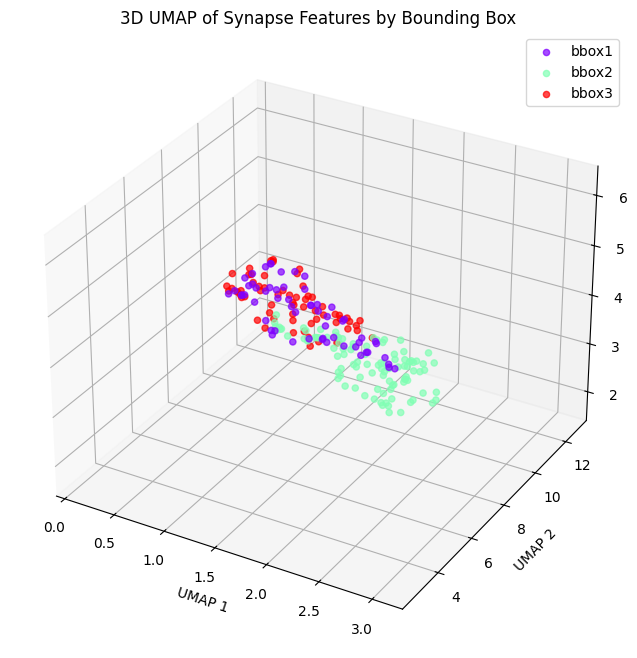

3D UMAP visualization completed.


In [2]:

scaler = StandardScaler()
all_features_scaled = scaler.fit_transform(all_features_combined)

pca = PCA(n_components=50, random_state=42)
all_features_pca = pca.fit_transform(all_features_scaled)

reducer = umap.UMAP(n_components=3, random_state=42)
embedding_3d = reducer.fit_transform(all_features_pca)

combined_synapse_df['UMAP_1'] = embedding_3d[:, 0]
combined_synapse_df['UMAP_2'] = embedding_3d[:, 1]
combined_synapse_df['UMAP_3'] = embedding_3d[:, 2]

bbox_unique = combined_synapse_df['bbox_name'].unique()
colors = plt.cm.rainbow(np.linspace(0,1,len(bbox_unique)))
color_map = dict(zip(bbox_unique, colors))

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

for bbox in bbox_unique:
    subset = combined_synapse_df[combined_synapse_df['bbox_name'] == bbox]
    ax.scatter(subset['UMAP_1'], subset['UMAP_2'], subset['UMAP_3'],
               color=tuple(color_map[bbox]), label=bbox, alpha=0.7)

ax.set_title("3D UMAP of Synapse Features by Bounding Box")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")
ax.legend()
plt.show()

print("3D UMAP visualization completed.")

In [3]:
import plotly.express as px
import pandas as pd

fig = px.scatter_3d(
    combined_synapse_df,
    x='UMAP_1',
    y='UMAP_2',
    z='UMAP_3',
    color='bbox_name'
)

fig.update_traces(marker=dict(size=3))
fig.show()
